In [ ]:
import os
import cv2
import numpy as np

In [ ]:
from PIL import Image

In [ ]:
from imutils import paths

In [ ]:
import imageio
import matplotlib.pyplot as plt
from skimage import morphology
from skimage.segmentation import watershed
from skimage.segmentation import random_walker
from skimage.feature import peak_local_max
from scipy import ndimage

In [ ]:
path=r"C:\Users\user\Documents\Computer_Vision\Final_year_project\eye_images\Images"

In [ ]:
pathToImages=list(paths.list_images(path))
data=[]
labels=[]

for images in pathToImages: 
    label=images.split(os.path.sep) 
    image=cv2.imread(images)
    image=cv2.resize(image,(244,244))
#     print(image)
    data.append(image)
    labels.append(label)

In [ ]:
data[0].shape

(244, 244, 3)

In [ ]:
data[0].size

178608

In [ ]:
equalized_images=[] # green channel
equalized_gr=[] #lab to green channel
for i in data:
    lab=cv2.cvtColor(i,cv2.COLOR_BGR2LAB) 
    l,a,b=cv2.split(lab)
    B, G, R = cv2.split(i)
    clahe=cv2.createCLAHE(clipLimit=2.5) 
    equalized=clahe.apply(G) 
    a2=clahe.apply(a)
    lab=cv2.merge((l,a2,b))
    img_end=cv2.cvtColor(lab,cv2.COLOR_LAB2BGR)
    Bl, Gr, Re = cv2.split(img_end)
    equalized_images.append(equalized)
    equalized_gr.append(Gr)

In [ ]:
# equalized_images is one list
# equalized_ gr is another list
# we need to perform segmentation on both the above lists to compare results of which is best

In [ ]:
equalized_images[0].shape

(244, 244)

In [ ]:
equalized_images[0].size

59536

In [ ]:
# test=equalized_images[1]
# ret,thresh=cv2.threshold(test,96,0,cv2.THRESH_TOZERO)
# cv2.imshow('thresholded ',thresh)
# cv2.imshow('orignal ',test)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# K means Segmentation

In [ ]:
def kmeansClustering(SegImg,partitions):
    img=SegImg.reshape((-1, 1))
    img=np.float32(img)
    criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 0.2)
    attempts=20
    ret,label,center=cv2.kmeans(img,partitions,None,criteria,attempts,cv2.KMEANS_RANDOM_CENTERS)
    result=center[label.flatten()]
    segmented_img=result.reshape((SegImg.shape))
    return label.reshape((SegImg.shape[0],SegImg.shape[1])),segmented_img.astype(np.uint8)

def extractComponent(SegImg,label_image,label):
    component=np.zeros(SegImg.shape,np.uint8)
    component1=np.zeros(SegImg.shape,np.uint8)
    component[label_image==label]=SegImg[label_image==label]
    component1[label_image==label]=255
    return component,component1

In [ ]:
partition=3
label,output=kmeansClustering(equalized_images[2],partition) #4 is the partition/no of clusters
kmeans_segment=output
cv2.imshow('Segmented img',output)
cv2.imshow('Preprocessed img',equalized_images[2])


output,output1=extractComponent(equalized_images[2],label,1) # 2 is the extracted portion
cv2.imshow('extracted img',output)
cv2.imshow('extracted binary img',output1)
cv2.waitKey(0)
cv2.destroyAllWindows()

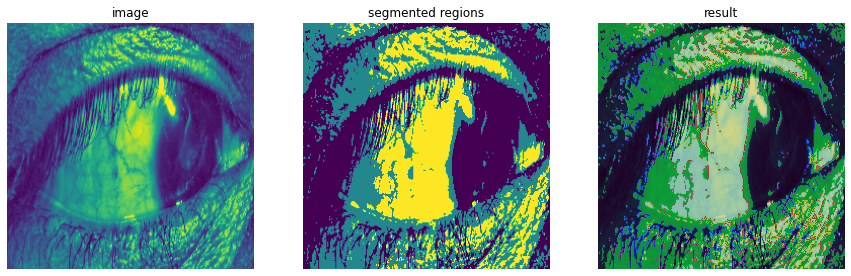

In [ ]:
label,output=kmeansClustering(equalized_images[2],partition)
fig,axes=plt.subplots(1,3, figsize=(15,5), sharex=True, sharey=True)
ax=axes.ravel()
axes[0].imshow(equalized_images[2]); axes[0].axis('off'); axes[0].set_title('image')
axes[1].imshow(output); axes[1].axis('off'); axes[1].set_title('segmented regions')
axes[2].imshow(equalized_images[2]); axes[2].axis('off'); axes[2].set_title('result')
axes[2].imshow(output, cmap=plt.cm.nipy_spectral, alpha=.6)

In [ ]:
def kmeansClustering(SegImg,partitions=3):
    img=SegImg.reshape((-1, 1))
    img=np.float32(img)
    criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 0.85)
    attempts=20
    ret,label,center=cv2.kmeans(img,partitions,None,criteria,attempts,cv2.KMEANS_RANDOM_CENTERS)
    result=center[label.flatten()]
    segmented_img=result.reshape((SegImg.shape))
    label=label.reshape((SegImg.shape[0],SegImg.shape[1]))
    output=segmented_img.astype(np.uint8)
    sclera=0
    for i in np.unique(label):
        if(center[i]==center.max()):
            sclera=i
    component=np.zeros(SegImg.shape,np.uint8)
    component1=np.zeros(SegImg.shape,np.uint8)
    component[label==sclera]=SegImg[label==sclera]
    component1[label==sclera]=255
    return component1
binary_mask=[]
for i in greens:
    output=kmeansClustering(i)
    binary_mask.append(output)
    
extracted_images=[]

for i in range(len(final_img)):
    B, G, R = cv2.split(final_mask[i])
    extracted_portion=cv2.bitwise_and(final_img[i],final_img[i],mask=G)
    extracted_images.append(extracted_portion)

In [ ]:
# label.shape

In [ ]:
# label==1 #True wherever it is 1

In [ ]:
# component=np.zeros(equalized_images[0].shape,np.uint8) 
# component[label==1]=equalized_images[0][label==1] # fill zeros with values from original img wwhere label=1/cluster1
# print(component)

# Watershed Segmentation

In [ ]:
seeds=20 # no of random pixels
random_seeds=np.zeros(equalized_images[0].shape) # random matrix with image size
# random 20 pixel points with x and y coordinates to itentofy them
indices=np.random.randint(0,equalized_images[0].shape,[seeds,2]) 
# adding those 20 pixel intensities into the random matrix of zeros of image  
random_seeds[indices[:,0],indices[:,1]]=equalized_images[0][indices[:,0],indices[:,1]]
# dialating the random seeds to make their size bigger 
random_seeds=morphology.dilation(random_seeds,morphology.disk(4)).astype(np.uint8)

In [ ]:
# dialating the image 
img_dil=morphology.dilation(equalized_images[2],morphology.disk(1).astype(np.uint8))
# eroding the image 
img_ero=morphology.erosion(equalized_images[2],morphology.disk(1).astype(np.uint8))
# getting the image gradient
img_grad=img_dil-img_ero

In [ ]:
# displaying gradient
cv2.imshow('gradient ',img_grad)
cv2.waitKey(0)
cv2.destroyAllWindows()

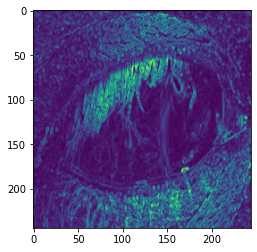

In [ ]:
plt.imshow(img_grad)

(-0.5, 243.5, 243.5, -0.5)

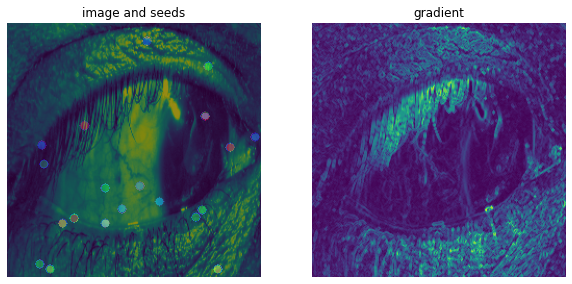

In [ ]:
fig,axes=plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)
ax=axes.ravel() # converts a 2 or multi dim array into a single contiguous array of size original_array.size
axes[0].imshow(equalized_images[2]); axes[0].set_title('image and seeds'); axes[0].axis('off')
axes[0].imshow(random_seeds, cmap=plt.cm.nipy_spectral, alpha=.4)
axes[1].imshow(img_grad); axes[1].set_title('gradient'); axes[1].axis('off')

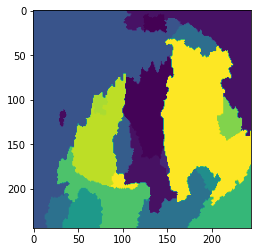

In [ ]:
# watershed segmentation
img_segment=watershed(img_grad,random_seeds)
plt.imshow(img_segment)

In [ ]:
# cv2.imshow('segmented image ',img_segment)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

(-0.5, 243.5, 243.5, -0.5)

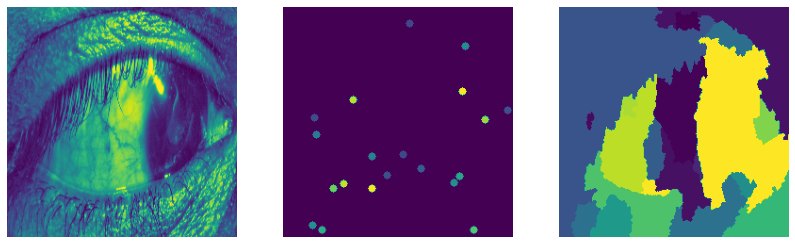

In [ ]:
plt.figure(figsize=(14,6))
plt.subplot(131); plt.imshow(equalized_images[2]); plt.axis('off')
plt.subplot(132); plt.imshow(random_seeds); plt.axis('off');
plt.subplot(133); plt.imshow(img_segment); plt.axis('off')

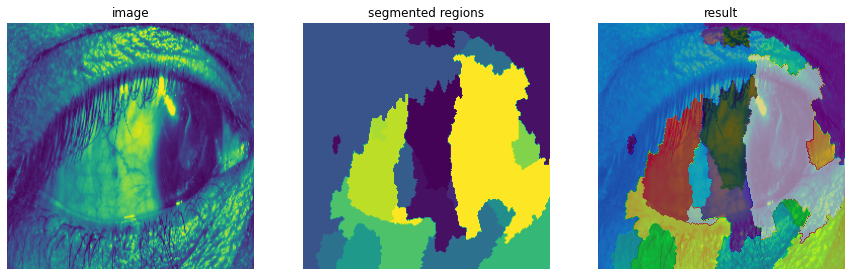

In [ ]:
fig,axes=plt.subplots(1,3, figsize=(15,5), sharex=True, sharey=True)
ax=axes.ravel()
axes[0].imshow(equalized_images[2]); axes[0].axis('off'); axes[0].set_title('image')
axes[1].imshow(img_segment); axes[1].axis('off'); axes[1].set_title('segmented regions')
axes[2].imshow(equalized_images[2]); axes[2].axis('off'); axes[2].set_title('result')
axes[2].imshow(img_segment, cmap=plt.cm.nipy_spectral, alpha=.6)

In [ ]:
img_segment=img_segment.astype(np.uint8)

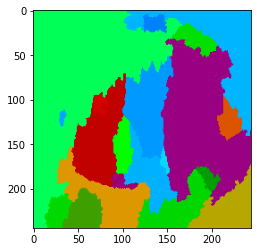

In [ ]:
import cmapy
img_segmented_colorized=cv2.applyColorMap(img_segment, cmapy.cmap('nipy_spectral_r'))
plt.imshow(img_segmented_colorized)
plt.show()

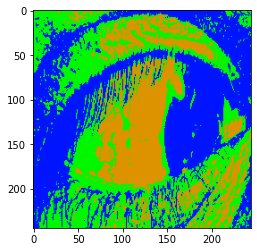

In [ ]:
import cmapy
kmeans_segmented_colorized=cv2.applyColorMap(kmeans_segment, cmapy.cmap('nipy_spectral_r'))
plt.imshow(kmeans_segmented_colorized)
plt.show()

In [ ]:
cv2.imshow('gradient ',img_segment)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
equalized_images[0]

array([[183, 186, 195, ..., 104,  99,  99],
       [178, 183, 195, ..., 104,  99,  96],
       [175, 180, 186, ..., 110,  99,  99],
       ...,
       [117, 114, 105, ..., 139, 153, 153],
       [117, 117, 114, ..., 136, 147, 141],
       [120, 123, 120, ..., 133, 139, 127]], dtype=uint8)

In [ ]:
np.unique(img_segment)

array([ 49,  51,  54,  57,  58,  69,  96, 102, 114, 116, 117, 138, 146,
       169, 179, 195, 206, 211, 228, 229], dtype=uint8)

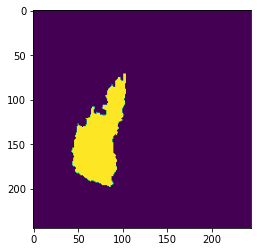

In [ ]:
dummy=np.zeros(equalized_images[0].shape,np.uint8)
dummy[img_segment==211]=211
plt.imshow(dummy)

In [ ]:
arr=np.unique(img_segment)
labels=[i for i in range(arr.size)]
labels

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

# Comparing k means and watershed segmentation

In [ ]:
compare=np.hstack((kmeans_segment,img_segment)) 
cv2.imshow('compare',compare)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
ML_split=[]
idx=0
lst=[]
ML_split_label=[]
for j in range(1,165):
  lst.clear()
  for i in indices_img:
    if(labels[i][-2]==str(j)):
      lst.append(data_1[i])
      # idx=idx+1
  for i in lst:
    ML_split.append(i)
  ML_split_label.append([j,len(lst)])
   # this contains the images in the list folder as needed for train test 
  # contains folder 1 in index 0 and folder 2 in index 1 and so on 